# Transfer Learning Custom Image from Fashion MNIST

## Import Packages

In [1]:
import os
import time
import torch
import torch.nn.functional as F

from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from os import listdir 
from itertools import chain 
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageOps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy
import warnings
warnings.filterwarnings('ignore')

## Prepare Data

In [2]:
IMG_SIZE = 128

transformer = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [3]:
PATH = "D:/Data Science Course/Startup Campus/FINAL PROJECT/DATA_FINAL/"

data = datasets.ImageFolder(PATH, transform=transformer)

TRAIN_SIZE = int(len(data) * 0.9)
TEST_SIZE = len(data) - TRAIN_SIZE

torch.manual_seed(10)

train_data, test_data = torch.utils.data.random_split(data, [TRAIN_SIZE, TEST_SIZE])

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100)

print(f'Train Data Length: {len(train_data)}')
print(f'Test Data Length: {len(test_data)}')

Train Data Length: 22770
Test Data Length: 2530


## Check Tensor Size & Image in Train Data

In [4]:
for images, labels in train_loader:
    break
    
images.shape

torch.Size([100, 1, 128, 128])

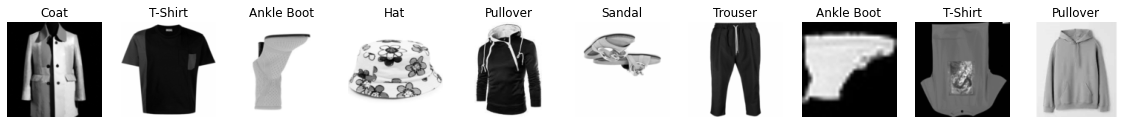

In [5]:
labels_data = {
    0: "Ankle Boot",
    1: "Bag",
    2: "Coat",
    3: "Dress",
    4: "Hat",
    5: "Pullover",
    6: "Sandal",
    7: "Shirt",
    8: "Sneaker",
    9: "T-Shirt",
    10: "Trouser" 
}

fig = plt.figure(figsize=(20, 8))
cols, rows = 10,1

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()

    img, label = test_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_data[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## Model

In [6]:
class Model(nn.Module):
    def __init__(self, in_channels=1):
        super(Model, self).__init__()

        self.model = models.mobilenet_v2(pretrained=True)
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.model.classifier[1] = nn.Sequential(
            nn.Linear(self.model.last_channel, 1000),
            nn.ReLU(),
            nn.Linear(1000, 11)
        )

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

### Use Private GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1050


In [8]:
model = Model().to(device)
model

Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

## Training 

In [10]:
data_size = len(train_data), len(test_data)
data_size

(22770, 2530)

In [11]:
def train(num_epochs=5):
    train_loss = []
    train_accuracy = []

    val_loss = []
    val_accuracy = []

    predictions_list = []
    labels_list = []

    best_loss = .9
    best_accuracy = 0

    start = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('-' * 10)

        train_correct = 0
        val_correct = 0


        for X_train, y_train in train_loader:
            model.train()
            X_train, y_train = X_train.to(device), y_train.to(device)

            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            predicted = torch.max(y_pred.data, 1)[1]
            train_correct += (predicted == y_train).sum()/data_size[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(train_correct.detach().cpu().numpy())

        print(f'loss: {loss}\naccuracy: {train_correct}\n')

        with torch.no_grad():
            for X_test, y_test in test_loader:
                model.eval()
                X_test, y_test = X_test.to(device), y_test.to(device)

                labels_list.append(y_test)

                y_val = model(X_test)

                predicted = torch.max(y_val.data, 1)[1]
                predictions_list.append(predicted)
                val_correct += (predicted == y_test).sum()/data_size[1]

        loss = criterion(y_val, y_test)
        val_loss.append(loss.detach().cpu().numpy())
        val_accuracy.append(val_correct.detach().cpu().numpy())
        print(f'val_loss: {loss}\nval_accuracy: {val_correct}\n\n')

        if best_accuracy < val_correct:
            if best_loss > loss:
                best_loss = loss
                best_accuracy = val_correct
                best_model = copy.deepcopy(model)

    end = time.time() - start

    print('-' * 10)
    print(f'Training time taken: {int(end/60)}min {int(end%60)}sec\n')
    print(f'Best val_accuracy: {best_accuracy}')
    print(f'Lowest val_loss: {best_loss}')

    return best_model, [train_loss, train_accuracy, val_loss, val_accuracy], [predictions_list, labels_list]

In [12]:
trained_model, result, preds_and_labels = train(10)

Epoch: 1/10
----------
loss: 0.20972785353660583
accuracy: 0.7817299962043762

val_loss: 0.33994877338409424
val_accuracy: 0.8905137777328491


Epoch: 2/10
----------
loss: 0.29371294379234314
accuracy: 0.9139658212661743

val_loss: 0.24750901758670807
val_accuracy: 0.8956521153450012


Epoch: 3/10
----------
loss: 0.1520616114139557
accuracy: 0.9320595860481262

val_loss: 0.1570008546113968
val_accuracy: 0.9335968494415283


Epoch: 4/10
----------
loss: 0.17959928512573242
accuracy: 0.9435223937034607

val_loss: 0.10395690053701401
val_accuracy: 0.9312252998352051


Epoch: 5/10
----------
loss: 0.19358272850513458
accuracy: 0.949802577495575

val_loss: 0.11068645864725113
val_accuracy: 0.9383400082588196


Epoch: 6/10
----------
loss: 0.2125735878944397
accuracy: 0.9579271078109741

val_loss: 0.1298092156648636
val_accuracy: 0.9450593590736389


Epoch: 7/10
----------
loss: 0.20897774398326874
accuracy: 0.9618356823921204

val_loss: 0.13894228637218475
val_accuracy: 0.9407114386558533

## Evaluation

In [13]:
train_loss = result[0]
train_accuracy = result[1]

val_loss = result[2]
val_accuracy = result[3]

dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':val_loss,
    'val_accuracy':val_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.20972785,0.78173,0.33994877,0.8905138
1,0.29371294,0.9139658,0.24750902,0.8956521
2,0.15206161,0.9320596,0.15700085,0.93359685
3,0.17959929,0.9435224,0.1039569,0.9312253
4,0.19358273,0.9498026,0.11068646,0.93834
5,0.21257359,0.9579271,0.12980922,0.94505936
6,0.20897774,0.9618357,0.13894229,0.94071144
7,0.2119998,0.9671062,0.3298522,0.9517787
8,0.16377419,0.9684676,0.1669545,0.94980234
9,0.0820772,0.9723323,0.08023722,0.9470356


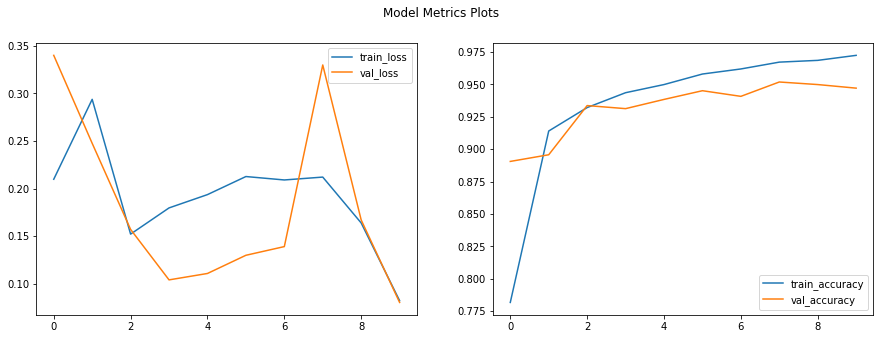

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [15]:
predictions_list = preds_and_labels[0]
labels_list = preds_and_labels[1]

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

print("Classification report for CNN :\n", classification_report(labels_l, predictions_l))

Classification report for CNN :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2350
           1       0.98      0.95      0.97      2340
           2       0.87      0.88      0.88      2400
           3       0.93      0.91      0.92      2300
           4       0.97      0.98      0.98      2100
           5       0.87      0.91      0.89      2670
           6       0.97      0.94      0.95      2180
           7       0.86      0.84      0.85      2400
           8       0.93      0.95      0.94      2200
           9       0.93      0.92      0.93      2250
          10       1.00      0.99      0.99      2110

    accuracy                           0.93     25300
   macro avg       0.94      0.93      0.93     25300
weighted avg       0.93      0.93      0.93     25300



## Save Model

In [16]:
PATH = f"D:/Data Science Course/Startup Campus/FINAL PROJECT/Model/mods_3.pt"
torch.save(trained_model.state_dict(), PATH)

## Load Model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1050


In [18]:
sirius_model = Model().to(device)
sirius_model.load_state_dict(torch.load(PATH))
sirius_model.eval()

Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(

In [19]:
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [20]:
def custom_image_pred(model, image_transforms, image_path, labels_data):
    image = Image.open(image_path)
    
    resize_image = image.resize((128, 128))  

    if image.mode == 'RGB':
        image = image.convert('L')
        image = ImageOps.invert(image)
    else:
        image = image.convert('L')

    image = image_transforms(image).float()
    image = image.unsqueeze(0).to(device)

    output = model(image)
    probs = F.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)

    return labels_data[classes.item()], round(conf.item(), 3), resize_image

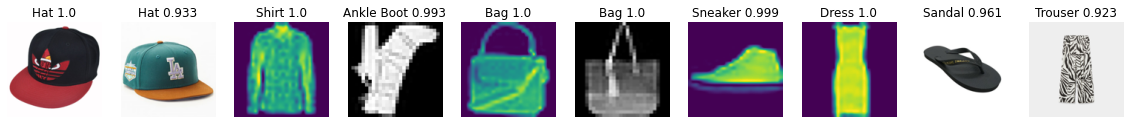

In [21]:
folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_1/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_2/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/internet_test/"

image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

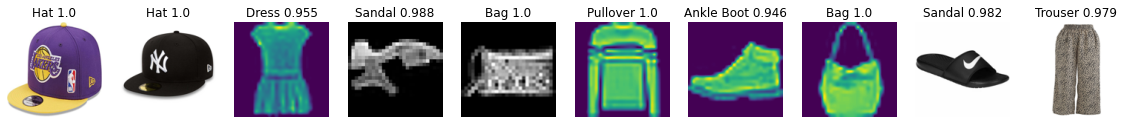

In [22]:
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_1/"
folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_2/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/internet_test/"

image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

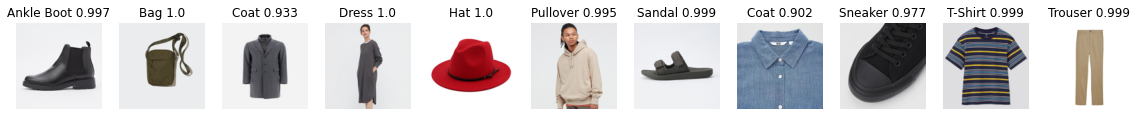

In [23]:
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_1/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_2/"
folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/internet_test/"

image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

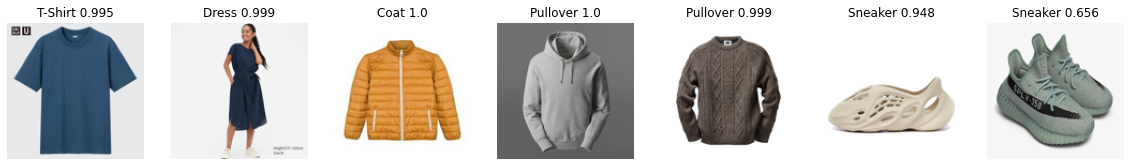

In [24]:
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_1/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/jury_test_2/"
# folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/internet_test/"
folder_dir = "D:/Data Science Course/Startup Campus/FINAL PROJECT/internet_test_2/"

image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()